# Setup
## Library import

In [2]:
import sys
sys.path.append(r'C:\Users\noesc\Desktop\PFE')
from dslib import *
from pathlib import Path
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import soundfile as sf
import scipy as sc
from scipy import signal
import xarray as xr
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import cv2
import random
import sklearn.metrics as metrics

## Path import

In [3]:

label_path = Path(r"C:/Users/noesc/Desktop/PFE/data/3446/labels/")  # adjust this path
#audio_path = r"D:/3441/flac/"

# Collect file names in a list
file_names = [f.name for f in label_path.iterdir() if f.is_file()]

# Quick stats :
## Number of detection per month

In [ ]:
i = 0
index = []
date = '00000000'
for name in file_names:
    if name[:8] != date:
        index.append(i)
    i+=1
    date = name[:8]
index.append(len(file_names))
print(index)

In [ ]:
data = np.zeros_like(index[:-1])
for i in range(len(data)):
    for name_str in file_names[index[i]:index[i+1]]:
        with open(str(label_path)+'/'+name_str) as file:
            contents = file.read()
        line_count = contents.count('\n')
        data[i] += line_count//2

date = []
for i in index[:-1]:
    date.append(file_names[i][6:8])

print(data)
plt.figure(figsize=(12,6))
plt.plot(date[1:],data[1:])
plt.title("distributions of detections of set 3441 / october 2016")
plt.xlabel("time (day)")
plt.ylabel("numbre of detections")
plt.show()

## Number of iteration of each pattern

In [67]:
label_path = Path(r"C:/Users/noesc/Desktop/PFE/data/3441/labels/")
file_names = [f.name for f in label_path.iterdir() if f.is_file()]

list_pattern = np.array([], dtype=str)  
count = np.array([])
for name_str in file_names:
    with open(str(label_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        data = list_content[2*i].split()
        pattern = data[2]
        if pattern in list_pattern:
            count[list_pattern==pattern] += 1
        else:
            list_pattern = np.append(list_pattern, pattern)
            count = np.append(count, 1)


print(list_pattern)
for i in range(list_pattern.size):
    print(list_pattern[i], int(count[i]))

['downsweep' 'arch-call' 'L-call' 'upsweep']
downsweep 2222
arch-call 1
L-call 36
upsweep 307


# Spectrogram handling
## Spectrogram display

In [ ]:
# Without library

#audio_name = file_names[23][:-3] + 'flac'
audio, fs = sf.read(r"E:\3501\flac\20161122T100000.flac")

n_fft = 4096
hop_length = n_fft*0.2
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

fmin, fmax = 0, 250
tmin, tmax = t[0], t[-1]
fmask = (f >= fmin) & (f <= fmax)
tmask = (t >= tmin) & (t <= tmax)
fslice = np.copy(f[fmask])
tslice = np.copy(t[tmask])
spec_data = np.copy(spectro[fmask,:][:,tmask])

# affichage du spectrogramme
font = {'family' : 'sans-serif', 'size'   : 18}
matplotlib.rc('font', **font)
params = {"font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)
matplotlib.rc('text', usetex=False)

matplotlib.rcParams["mathtext.fontset"]='cm'
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig = plt.figure(figsize=[16,4])
im = plt.pcolormesh(tslice/60,fslice,20*np.log10(abs(spec_data)))
bmax = -30
bmin = bmax - 80

plt.xlabel(r'$\rm{Time\ [min]}$')
plt.ylabel(r'$\rm{Frequency\ [Hz]}$')

plt.clim([bmin,bmax])
plt.colorbar(im, label= '[dB]')
fig.set_facecolor("white")

plt.show()

In [ ]:
# With library

#audio_name = file_names[245][:-3] + 'flac'
audio, fs = sf.read(r"E:\3501\flac\20161122T100000.flac")

n_fft = 4096
hop_length = n_fft*0.2
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

fmin, fmax = 0, 250
tmin, tmax = t[0], t[-1]
fmask = (f >= fmin) & (f <= fmax)
tmask = (t >= tmin) & (t <= tmax)
fslice = np.copy(f[fmask])
tslice = np.copy(t[tmask])
spec_data = np.copy(spectro[fmask,:][:,tmask])

plot_spectro(spec= spec_data, freq= fslice, time= tslice, gain= 30, title= "20160312T071601")

## Display of individual pattern

In [ ]:
#Without library

label_name = file_names[23]
audio_name = label_name[:-3] + 'flac'
audio, fs = sf.read(audio_path+audio_name)

n_fft = 4096
hop_length = n_fft*0.2
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

with open(str(label_path)+'/'+label_name) as file:
    contents = file.read()
line_count = contents.count('\n')//2
list_content = contents.split('\n')

i=0
#for i in range(line_count):
delta_time = list_content[2*i].split()
delta_freq = list_content[2*i+1][3:].split()
pattern = delta_time[2]
tmin, tmax = float(delta_time[0]), float(delta_time[1])
fmin, fmax = float(delta_freq[0]), float(delta_freq[1])

fmask = (f >= fmin) & (f <= fmax)
tmask = (t >= tmin) & (t <= tmax)
fslice = np.copy(f[fmask])
tslice = np.copy(t[tmask])
spec_data = np.copy(spectro[fmask,:][:,tmask])

# affichage du spectrogramme
font = {'family' : 'sans-serif', 'size'   : 18}
matplotlib.rc('font', **font)
params = {"font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)
matplotlib.rc('text', usetex=False)

matplotlib.rcParams["mathtext.fontset"]='cm'
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig = plt.figure(figsize=[7,5])
im = plt.pcolormesh(tslice/60,fslice,20*np.log10(abs(spec_data)))
bmax = -40
bmin = bmax - 80

plt.xlabel(r'$\rm{Temps\ (min)}$')
plt.ylabel(r'$f\ \rm{(Hz)}$')
plt.title("spectrogramme " + audio_name +" "+ pattern +" t="+ str(round(tmin*100/60)/100), loc= 'center')

plt.clim([bmin,bmax])
plt.colorbar(im, label= 'dB')
fig.set_facecolor("white")
plt.show()

In [ ]:
#With library
 
audio, fs = sf.read(r"D:\Gregoire_Malo\3446\flac\flac\20160312T071501.flac")

n_fft = 4096
hop_length = n_fft*0.2
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

with open(r"C:\Users\noesc\Desktop\PFE\data\3446\labels\20160312T071501.txt") as file:
    contents = file.read()
line_count = contents.count('\n')//2
list_content = contents.split('\n')

i=0
#for i in range(line_count):
delta_time = list_content[2*i].split()
delta_freq = list_content[2*i+1][3:].split()
pattern = delta_time[2]
tmin, tmax = float(delta_time[0]), float(delta_time[1])
tmoy = (tmin+tmax)/2
fmin, fmax = 0,250

fmask = (f >= fmin) & (f <= fmax)
tmask = (t >= tmoy-3.5) & (t <= tmoy+3.5)
fslice = np.copy(f[fmask])
tslice = np.copy(t[tmask])
spec_data = np.copy(spectro[fmask,:][:,tmask])

plot_spectro(spec= spec_data, freq= fslice, time= tslice, gain= 30, size=[7,5], unit='s')

## Storing patterns in a xarray dataset file

In [ ]:
# Without library

label_name = file_names[245]
audio_name = label_name[:-3] + 'flac'
audio, fs = sf.read(audio_path+audio_name)

n_fft = 4096
hop_length = n_fft*0.2
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

with open(str(label_path)+'/'+label_name) as file:
    contents = file.read()
line_count = contents.count('\n')//2
list_content = contents.split('\n')

ds = xr.Dataset(
    data_vars=dict(
        spectrogram_real = (["freq", "time"], spectro.real),
        spectrogram_imag = (["freq", "time"], spectro.imag),
        pattern = (["index"], range(line_count)),
    ),
    coords=dict(
        index = range(line_count),
        freq = f,
        time = t,
        dim = [0,1]
    ),
)

mask = np.stack([np.full_like(spectro, np.nan)]*line_count, axis=0)
mask_f = np.stack([np.full_like(f, np.nan)]*line_count, axis=0)
mask_t = np.stack([np.full_like(t, np.nan)]*line_count, axis=0)
for i in range(line_count):
    delta_time = list_content[2*i].split()
    delta_freq = list_content[2*i+1][3:].split()

    pattern = delta_time[2]
    tmin, tmax = float(delta_time[0]), float(delta_time[1])
    fmin, fmax = float(delta_freq[0]), float(delta_freq[1])

    fmask = (f >= fmin) & (f <= fmax)
    tmask = (t >= tmin) & (t <= tmax)

    fslice = np.full_like(f, np.nan)
    tslice = np.full_like(t, np.nan)
    fslice[np.ix_(fmask)] = np.copy(f[np.ix_(fmask)])
    tslice[np.ix_(tmask)] = np.copy(t[np.ix_(tmask)])
    mask_f[i] = np.copy(fslice)
    mask_t[i] = np.copy(tslice)

    spec_data = np.full_like(spectro, np.nan)
    spec_data[np.ix_(fmask, tmask)] = np.copy(spectro[np.ix_(fmask, tmask)])
    mask[i] = np.copy(spec_data)


ds = ds.assign(mask_real = (["index", "freq", "time"],mask.real))
ds = ds.assign(mask_imag = (["index", "freq", "time"],mask.imag))
ds = ds.assign(mask_f = (["index", "freq"], mask_f))
ds = ds.assign(mask_t = (["index", "time"], mask_t))

ds.to_netcdf(r"C:/Users/noesc/Desktop/PFE/data/3441/spec_cross/"+label_name[:-3]+"nc")

In [ ]:
# With library

label_name = file_names[199]
audio_name = label_name[:-3] + 'flac'
audio, fs = sf.read(audio_path+audio_name)

n_fft = 4096
hop_length = n_fft*0.2
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

ds2 = build_ds(full_spec= spectro, freq= f, time= t, label_path= str(label_path)+'/'+label_name)

ds2.to_netcdf(r"C:/Users/noesc/Desktop/PFE/data/3441/spec_cross/"+label_name[:-3]+"nc")

## open dataset file and display individual pattern

In [ ]:
ds1 = xr.open_dataset(r"C:\Users\noesc\Desktop\PFE\data\3441\spec_cross\20161017T173001.nc")

k = 0
a = np.copy(ds1.mask_real[k] + 1j*ds1.mask_imag[k])
b = np.copy(ds1.mask_f[k])
b = b[~np.isnan(b)]
c = np.copy(ds1.mask_t[k])
c = c[~np.isnan(c)]
a = a[~np.isnan(a)].reshape(b.size, c.size)

font = {'family' : 'sans-serif', 'size'   : 18}
matplotlib.rc('font', **font)
params = {"font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)
matplotlib.rc('text', usetex=False)

matplotlib.rcParams["mathtext.fontset"]='cm'
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig = plt.figure(figsize=[7,5])
im = plt.pcolormesh(c/60,b,20*np.log10(abs(a)))
bmax = -40
bmin = bmax - 80

plt.xlabel(r'$\rm{Temps\ (min)}$')
plt.ylabel(r'$f\ \rm{(Hz)}$')
plt.title("spectrogramme " + str(k), loc= 'center')

plt.clim([bmin,bmax])
plt.colorbar(im, label= 'dB')
fig.set_facecolor("white")
plt.show()

In [ ]:
k = 0
a = np.copy(ds2.mask_real[k] + 1j*ds2.mask_imag[k])
b = np.copy(ds2.mask_f[k])
b = b[~np.isnan(b)]
c = np.copy(ds2.mask_t[k])
c = c[~np.isnan(c)]
a = a[~np.isnan(a)].reshape(b.size, c.size)
p = ds2.pattern[k].data

plot_spectro(spec= a, freq= b, time= c, gain=40, title= 'spectrogram index '+str(k)+' / pattern : '+p, size=[7,5])

In [ ]:
fslice, tslice, spectro, pattern, ds1 = open_ds(path= r"D:\3441\spectrograms\20160920T141501.nc", index= 5, display= True)

In [ ]:
_ = spec_ds(path= r"D:\Gregoire_Malo\3446\flac\spectrograms\20160312T071501.nc", display= True)

# Automation for an entire dataset

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3501'
audio_path = r"D:\3501\flac"

# Collect file names in a list
label_path = Path(dataset_path + r'\labels')
file_names = [f.name for f in label_path.iterdir() if f.is_file()]

def work(label_name):
    audio_name = label_name[:-3] + 'flac'
    audio, fs = sf.read(audio_path+'/'+audio_name)

    n_fft = 4096
    hop_length = n_fft*0.2
    f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

    ds2 = build_ds(full_spec= spectro, freq= f, time= t, label_path= str(label_path)+'/'+label_name)

    ds2.to_netcdf(r"D:\3501\spectrograms"+'/'+label_name[:-3]+"nc")
    return

with ThreadPoolExecutor() as executor:
   executor.map(work, file_names)

# cross-annotation
## Extracting data from a single file

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3441'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
kappa = np.zeros_like(cross_names)
#for k in range(len(kappa))
#pointer = cross_names[2]
pointer = r'20161008T100001.txt'
if pointer in label_names:
    # extraction des données du set cross
    
    with open(str(cross_path)+'/'+pointer) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    
    cross_coords = np.zeros(line_count)
    cross_pattern = np.array([])

    for i in range(line_count):
        delta_time = list_content[2*i].split()
        delta_freq = list_content[2*i+1][3:].split()

        cross_pattern = np.append(cross_pattern, delta_time[2])
        tmin, tmax = float(delta_time[0]), float(delta_time[1])
        tmoy = (tmin + tmax)/2
        cross_coords[i] = tmoy
    
    # extraction des données du set originel
    
    with open(str(label_path)+'/'+pointer) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    
    label_coords = np.zeros(line_count)
    label_pattern = np.array([])

    for i in range(line_count):
        delta_time = list_content[2*i].split()
        delta_freq = list_content[2*i+1][3:].split()

        label_pattern = np.append(label_pattern, delta_time[2])
        tmin, tmax = float(delta_time[0]), float(delta_time[1])
        tmoy = (tmin + tmax)/2
        label_coords[i] = tmoy
else : print('osef')


In [ ]:
epsilon = 1.3

# Find the max length
max_len = np.max([cross_coords.size, label_coords.size])

# Compare and collect indices where they differ
same_pattern = np.array([])
for i in range(max_len):
    time_cross = cross_coords[i] if i<cross_coords.size else np.nan
    time_label = label_coords[i] if i<label_coords.size else np.nan
    if abs(time_cross-time_label) < epsilon :
        same_pattern = np.append(same_pattern, (time_cross + time_label)/2)
    else :
        same_pattern = np.append(same_pattern, time_cross) if np.any(np.isclose(label_coords, time_cross, atol= epsilon)) else same_pattern
        #same_pattern = np.append(same_pattern, time_label) if np.any(np.isclose(cross_coords, time_label, atol= epsilon)) and not np.any(np.isclose(same_pattern, time_label, atol= epsilon)) else same_pattern
        

In [ ]:
print(pointer)
print(cross_coords)
print(label_coords)
print(same_pattern)

In [ ]:
f, t, spec, n_pat, _ = spec_ds(path= r"E:\3441\spec_cross\20161008T100001.nc", display=True)

fmin, fmax = 0, 250
tmin, tmax = 120, 270
fmask = (f >= fmin) & (f <= fmax)
tmask = (t >= tmin) & (t <= tmax)
freq = np.copy(f[fmask])
time = np.copy(t[tmask])
spec_data = np.copy(spec[fmask,:][:,tmask])

cross_coords_2 = cross_coords[cross_coords>tmin]

font = {'family' : 'sans-serif', 'size'   : 18}
matplotlib.rc('font', **font)
params = {"font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)
matplotlib.rc('text', usetex=False)

matplotlib.rcParams["mathtext.fontset"]='cm'
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig = plt.figure(figsize=[16,4])
im = plt.pcolormesh(time/60,freq,20*np.log10(abs(spec_data)))
bmax = -30
bmin = bmax - 80

plt.xlabel(r'$\rm{Time\ [min]}$')
plt.ylabel(r'$f\ \rm{[Hz]}$')
plt.title(str(pointer), loc= 'center')

plt.clim([bmin,bmax])
plt.colorbar(im, label= '[dB]')
fig.set_facecolor("white")
plt.vlines(cross_coords_2/60, fmin, fmax-1, colors='r')
plt.vlines(label_coords/60, fmin, fmax-1, colors='y')
plt.vlines(same_pattern/60, fmin, fmax-1, colors="#00faf2", linestyles='dotted')
plt.legend(["annotator 1", "annotator 2", "agreement"])
plt.show()


In [ ]:
# image histogram
for i in range(n_pat):
    
    freq, time, spec, _, _ = open_ds(path= r"E:\3441\spec_cross\201610"+pointer[6:-3]+"nc",index= i)
    spec_aff = 20*np.log10(abs(spec))
    histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
    hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)

    font = {'family' : 'sans-serif', 'size'   : 18}
    matplotlib.rc('font', **font)
    params = {"font.serif" : ["Computer Modern Serif"]}
    plt.rcParams.update(params)
    matplotlib.rc('text', usetex=False)

    matplotlib.rcParams["mathtext.fontset"]='cm'
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    plt.figure(figsize=[16,5])
    ax1 = plt.subplot(1,2,1)
    plt.pcolormesh(time/60,freq,spec_aff)
    bmax = -30
    bmin = bmax - 80

    #plt.xlabel(r'$\rm{Time\ (min)}$')
    #plt.ylabel(r'$f\ \rm{(Hz)}$')
    #plt.title(title, loc= 'center')

    plt.clim([bmin,bmax])
    plt.colorbar(im, label= 'dB')
    ax1.set_facecolor("white")

    ax2 = plt.subplot(1,2,2)
    plt.plot(bins[:-1], hist_filt)
    plt.show()
    
    test = np.sum(hist_filt[bins[:-1]>-70])
    seuil = 15
    print(test>=seuil)


In [ ]:
cross_pattern_mask = np.array([])
label_pattern_mask = np.array([])
for t_pat in same_pattern : 
    cross_pattern_mask = np.append(cross_pattern_mask, cross_pattern[np.isclose(cross_coords, t_pat, atol=epsilon)])
    label_pattern_mask = np.append(label_pattern_mask, label_pattern[np.isclose(label_coords, t_pat, atol=epsilon)])
n_agree = len(cross_pattern_mask==label_pattern_mask)


## Iteration sur tout le mois : kappa sans filtre

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3446'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
month = '201610'

n_label = 0
n_cross = 0
n_agree = 0
n_disagree = 0

for pointer in cross_names:
    if pointer in label_names:
        # extraction des données du set cross
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        n_cross += line_count
        
        cross_coords = np.zeros(line_count)
        cross_pattern = np.array([])

        for i in range(line_count):
            delta_time = list_content[2*i].split()
            delta_freq = list_content[2*i+1][3:].split()

            cross_pattern = np.append(cross_pattern, delta_time[2])
            tmin, tmax = float(delta_time[0]), float(delta_time[1])
            tmoy = (tmin + tmax)/2
            cross_coords[i] = tmoy
        
        # extraction des données du set originel
        
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        n_label += line_count
        
        label_coords = np.zeros(line_count)
        label_pattern = np.array([])

        for i in range(line_count):
            delta_time = list_content[2*i].split()
            delta_freq = list_content[2*i+1][3:].split()

            label_pattern = np.append(label_pattern, delta_time[2])
            tmin, tmax = float(delta_time[0]), float(delta_time[1])
            tmoy = (tmin + tmax)/2
            label_coords[i] = tmoy
        
        epsilon = 1.3

        # Find the max length
        max_len = np.max([cross_coords.size, label_coords.size])

        # Compare and collect indices where they differ
        same_pattern = np.array([])
        for i in range(max_len):
            time_cross = cross_coords[i] if i<cross_coords.size else np.nan
            time_label = label_coords[i] if i<label_coords.size else np.nan
            if abs(time_cross-time_label) < epsilon :
                same_pattern = np.append(same_pattern, (time_cross + time_label)/2)
            else :
                same_pattern = np.append(same_pattern, time_cross) if np.any(np.isclose(label_coords, time_cross, atol= epsilon)) else same_pattern
        
        cross_pattern_mask = np.array([])
        label_pattern_mask = np.array([])
        for t_pat in same_pattern : 
            cross_pattern_mask = np.append(cross_pattern_mask, cross_pattern[np.isclose(cross_coords, t_pat, atol=epsilon)])
            label_pattern_mask = np.append(label_pattern_mask, label_pattern[np.isclose(label_coords, t_pat, atol=epsilon)])
        n_agree += len(cross_pattern_mask==label_pattern_mask)
        
        yes = True
        '''
        for i in range(max_len):
            if i<cross_coords.size and not np.any(np.isclose(same_pattern, cross_coords[i], atol=epsilon)):
                print(pointer, " Noé")
                _ = open_ds(dataset_path + '/spec_cross/'+pointer[:-3]+'nc', i, display= True)
                yes = True
            if i<label_coords.size and not np.any(np.isclose(same_pattern, label_coords[i], atol=epsilon)):
                print(pointer, " Alexis")
                _ = open_ds(dataset_path + '/spectrograms/'+pointer[:-3]+'nc', i, display= True)
                yes = True
        '''
        if yes :
            f, t, spec, _, _ = spec_ds(path= r"C:\Users\noesc\Desktop\PFE\data\3441\spec_cross\201610"+pointer[6:-3]+"nc", display=True)

            fmin, fmax = 0, 250
            tmin, tmax = t[0], t[-1]
            fmask = (f >= fmin) & (f <= fmax)
            tmask = (t >= tmin) & (t <= tmax)
            freq = np.copy(f[fmask])
            time = np.copy(t[tmask])
            spec_data = np.copy(spec[fmask,:][:,tmask])

            font = {'family' : 'sans-serif', 'size'   : 18}
            matplotlib.rc('font', **font)
            params = {"font.serif" : ["Computer Modern Serif"]}
            plt.rcParams.update(params)
            matplotlib.rc('text', usetex=False)

            matplotlib.rcParams["mathtext.fontset"]='cm'
            matplotlib.rcParams['text.usetex'] = False
            matplotlib.rcParams.update(matplotlib.rcParamsDefault)

            fig = plt.figure(figsize=[16,4])
            im = plt.pcolormesh(time/60,freq,20*np.log10(abs(spec_data)))
            bmax = -40
            bmin = bmax - 80

            plt.xlabel(r'$\rm{Time\ (min)}$')
            plt.ylabel(r'$f\ \rm{(Hz)}$')
            plt.title(str(pointer), loc= 'center')

            plt.clim([bmin,bmax])
            plt.colorbar(im, label= 'dB')
            fig.set_facecolor("white")
            plt.vlines(cross_coords/60, fmin, fmax-1, colors='r')
            plt.vlines(label_coords/60, fmin, fmax-1, colors='y')
            plt.vlines(same_pattern/60, fmin, fmax-1, colors="#00faf2", linestyles='dotted')
            plt.legend(["annotator 1", "annotator 2", "agreement"])
            plt.show()
            
    else:
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        n_cross += line_count

for pointer in [name for name in label_names if name.startswith(month)]:
    if pointer not in cross_names:
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2

        n_label += line_count
        


In [ ]:
plt.figure(figsize= [7,5])
plt.plot(bins[:-1], hist_agree/n_agree)
plt.plot(bins[:-1], hist_disagree/n_disagree)
plt.plot(bins[:-1], abs(hist_agree/n_agree-hist_disagree/n_disagree))
plt.vlines(-74, 0, 20)
plt.show()

In [ ]:
list_pattern = np.array([], dtype=str)  
label_count = np.array([])
for name_str in [name for name in label_names if name.startswith(month)]:
    with open(str(label_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        data = list_content[2*i].split()
        pattern = data[2]
        if pattern in list_pattern:
            label_count[list_pattern==pattern] += 1
        else:
            list_pattern = np.append(list_pattern, pattern)
            label_count = np.append(label_count, 1)

cross_count = np.zeros_like(list_pattern, dtype=int)
for name_str in cross_names:
    with open(str(cross_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        data = list_content[2*i].split()
        pattern = data[2]
        if pattern in list_pattern:
            cross_count[list_pattern==pattern] += 1
        else:
            list_pattern = np.append(list_pattern, pattern)
            cross_count = np.append(cross_count, 1)
         

In [ ]:

n_tot = n_cross + n_label - n_agree

P0 = n_agree/n_tot
Pe = (cross_count[0]*label_count[0]+cross_count[1]*label_count[1]+(n_tot-n_cross)*(n_tot-n_label))/n_tot**2
kappa = (P0-Pe)/(1-Pe)

print('kappa = ', round(kappa*100)/100)
print(n_agree, n_tot)

## Iteration sur tout le mois : kappa avec filtre

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3441'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
month = '201610'
seuil = 20
palier = 80

n_label = 0
n_cross = 0
n_agree = 0
hist_agree = np.zeros(128)
hist_disagree = np.zeros(128)
for pointer in cross_names:
    if pointer in label_names:
        # extraction des données du set cross
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        cross_coords = np.zeros(line_count)
        cross_pattern = np.array([])

        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
            #hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                cross_pattern = np.append(cross_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                cross_coords[i] = tmoy
                n_cross += 1
            else:
                cross_pattern = np.append(cross_pattern, None)
                cross_coords[i]=np.nan
        
        # extraction des données du set originel
        
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        label_coords = np.zeros(line_count)
        label_pattern = np.array([])

        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spectrograms/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
            #hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                label_pattern = np.append(label_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                label_coords[i] = tmoy
                n_label +=1
            else:
                label_pattern = np.append(label_pattern, None)
                label_coords[i] = np.nan
        
        epsilon = 1.3

        # Find the max length
        max_len = np.max([cross_coords.size, label_coords.size])

        # Compare and collect indices where they differ
        same_pattern = np.array([])
        for i in range(max_len):
            time_cross = cross_coords[i] if i<cross_coords.size else np.nan
            time_label = label_coords[i] if i<label_coords.size else np.nan
            if abs(time_cross-time_label) < epsilon :
                same_pattern = np.append(same_pattern, (time_cross + time_label)/2)
            else :
                same_pattern = np.append(same_pattern, time_cross) if np.any(np.isclose(label_coords, time_cross, atol= epsilon)) else same_pattern
        
        cross_pattern_mask = np.array([])
        label_pattern_mask = np.array([])
        for t_pat in same_pattern : 
            cross_pattern_mask = np.append(cross_pattern_mask, cross_pattern[np.isclose(cross_coords, t_pat, atol=epsilon)])
            label_pattern_mask = np.append(label_pattern_mask, label_pattern[np.isclose(label_coords, t_pat, atol=epsilon)])
        n_agree += len(cross_pattern_mask==label_pattern_mask)

        
        f, t, spec, n_pat, _ = spec_ds(path= r"E:\3441\spec_cross\201610"+pointer[6:-3]+"nc")

        fmin, fmax = 0, 250
        tmin, tmax = 120, 270
        fmask = (f >= fmin) & (f <= fmax)
        tmask = (t >= tmin) & (t <= tmax)
        freq = np.copy(f[fmask])
        time = np.copy(t[tmask])
        spec_data = np.copy(spec[fmask,:][:,tmask])

        font = {'family' : 'sans-serif', 'size'   : 18}
        matplotlib.rc('font', **font)
        params = {"font.serif" : ["Computer Modern Serif"]}
        plt.rcParams.update(params)
        matplotlib.rc('text', usetex=False)

        matplotlib.rcParams["mathtext.fontset"]='cm'
        matplotlib.rcParams['text.usetex'] = False
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)

        fig = plt.figure(figsize=[16,4])
        im = plt.pcolormesh(time/60,freq,20*np.log10(abs(spec_data)))
        bmax = -40
        bmin = bmax - 80

        plt.xlabel(r'$\rm{Time\ [min]}$')
        plt.ylabel(r'$f\ \rm{[Hz]}$')
        plt.title(str(pointer), loc= 'center')
        
        plt.clim([bmin,bmax])
        plt.colorbar(im, label= '[dB]')
        fig.set_facecolor("white")
        plt.vlines(cross_coords/60, fmin, fmax-1, colors='r')
        plt.vlines(label_coords/60, fmin, fmax-1, colors='y')
        plt.vlines(same_pattern/60, fmin, fmax-1, colors="#00faf2", linestyles='dotted')
        plt.legend(["annotator 1", "annotator 2", "agreement"])
        plt.show()
        
    else:
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
            #hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                n_cross += 1

for pointer in [name for name in label_names if name.startswith(month)]:
    if pointer not in cross_names:
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spectrograms/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
            #hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                n_label += 1

list_pattern = np.array([], dtype=str)  
label_count = np.array([])
for name_str in [name for name in label_names if name.startswith(month)]:
    with open(str(label_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        _, _, spec, _, _ = open_ds(path= r"E:\3441/spectrograms/"+name_str[:-3]+"nc",index= i)
        spec_aff = 20*np.log10(abs(spec))
        histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
        #hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)
        test = np.sum(histogram[bins[:-1]>-palier])
        if test>=seuil:
            data = list_content[2*i].split()
            pattern = data[2]
            if pattern in list_pattern:
                label_count[list_pattern==pattern] += 1
            else:
                list_pattern = np.append(list_pattern, pattern)
                label_count = np.append(label_count, 1)


cross_count = np.zeros_like(list_pattern, dtype=int)
for name_str in cross_names:
    with open(str(cross_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        _, _, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+name_str[:-3]+"nc",index= i)
        spec_aff = 20*np.log10(abs(spec))
        histogram, bins = np.histogram(spec_aff, bins= 128, range= (-80,-30))
        #hist_filt = sc.ndimage.gaussian_filter1d(histogram,sigma=0.6)
        test = np.sum(histogram[bins[:-1]>-palier])
        if test>=seuil:
            data = list_content[2*i].split()
            pattern = data[2]
            if pattern in list_pattern:
                cross_count[list_pattern==pattern] += 1
            else:
                list_pattern = np.append(list_pattern, pattern)
                cross_count = np.append(cross_count, 1)
            
n_tot = n_cross + n_label - n_agree

P0 = n_agree/n_tot
Pe = (cross_count[0]*label_count[0]+cross_count[1]*label_count[1]+(n_tot-n_cross)*(n_tot-n_label))/n_tot**2
kappa= (P0-Pe)/(1-Pe)

#print('kappa = ', round(kappa*100)/100)
print('kappa = ', kappa)
print('n_agree = ', n_agree)
print('n_tot = ', n_tot)

# methode STA/LTA

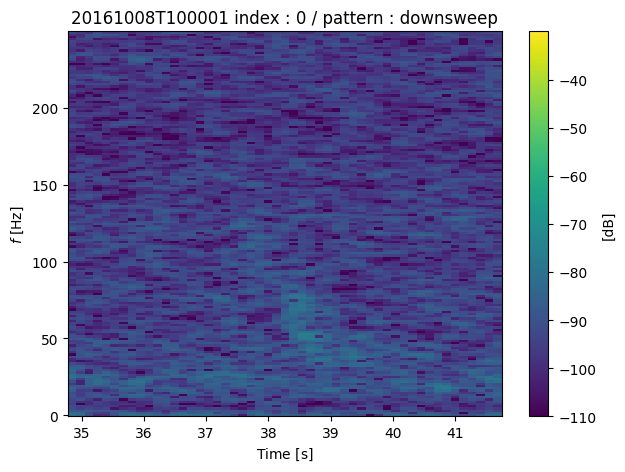

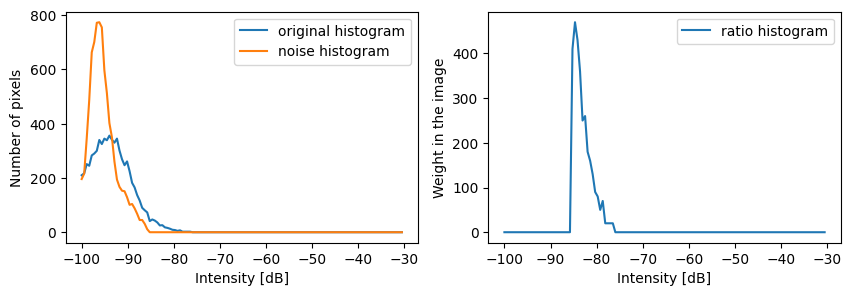

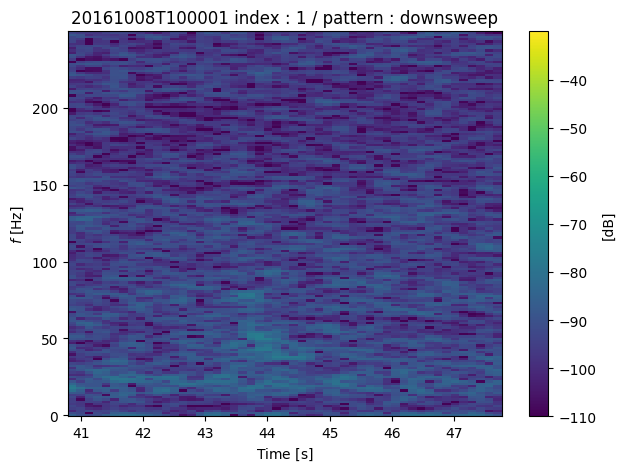

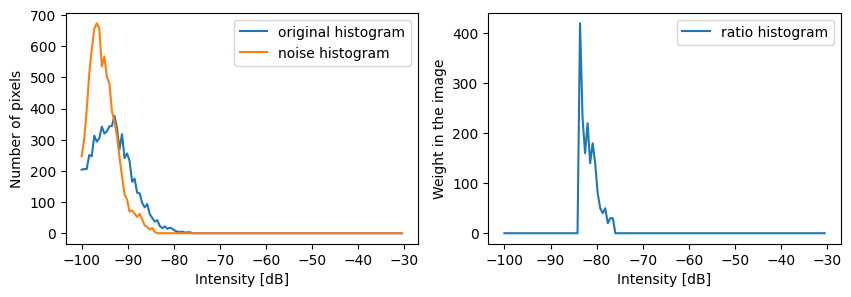

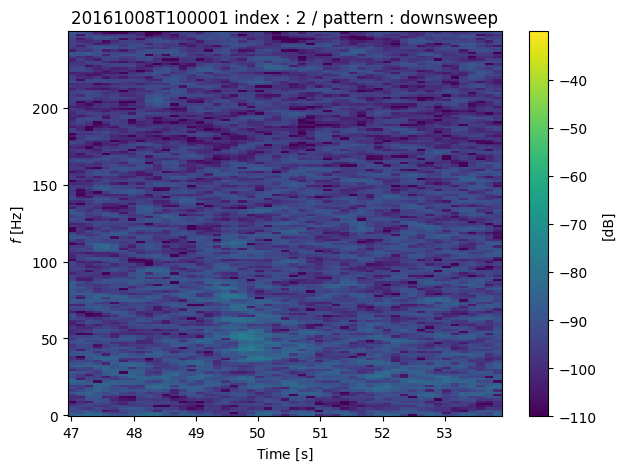

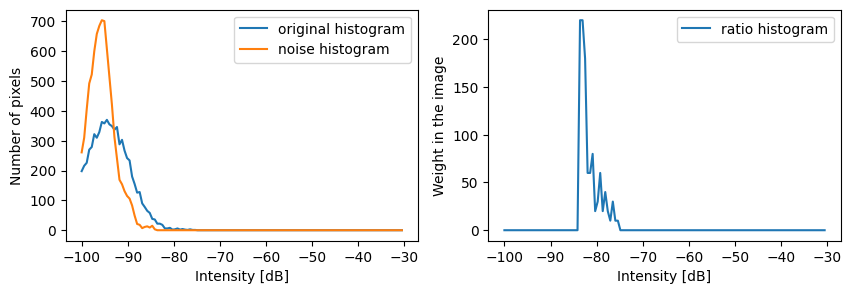

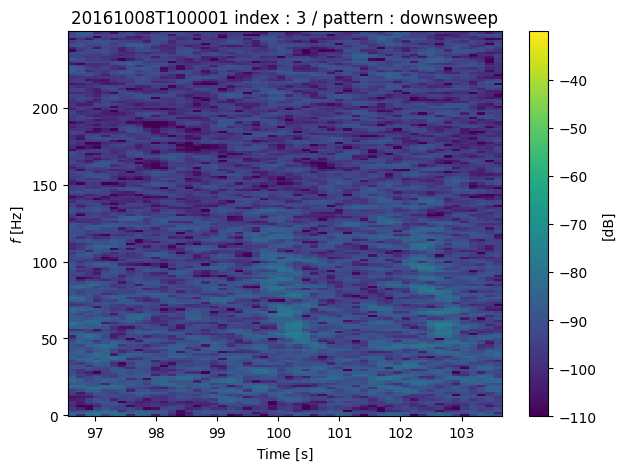

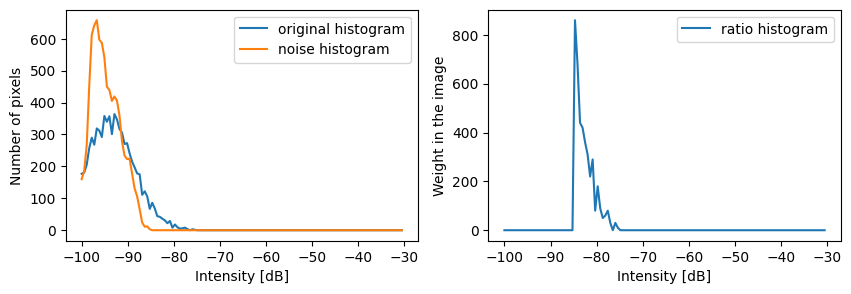

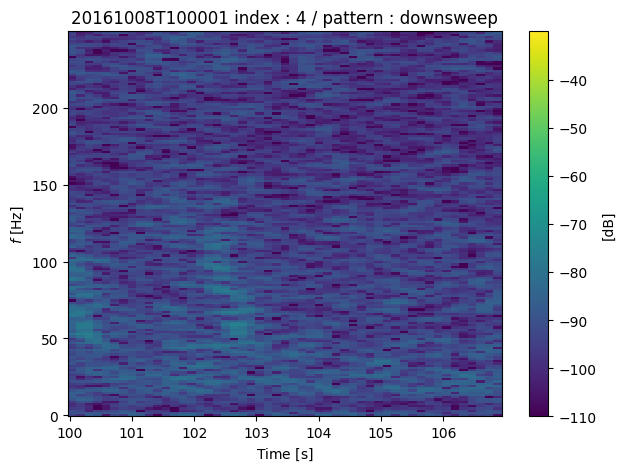

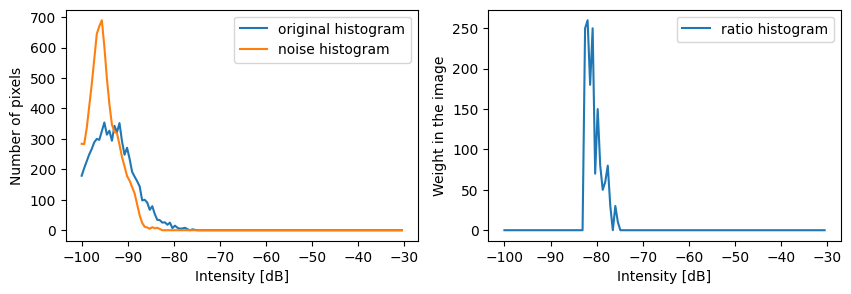

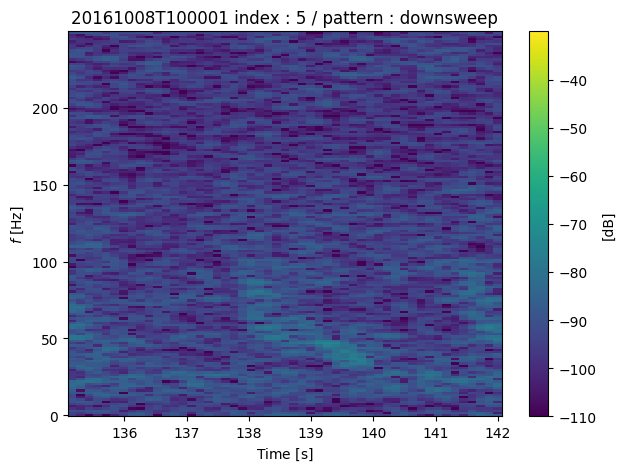

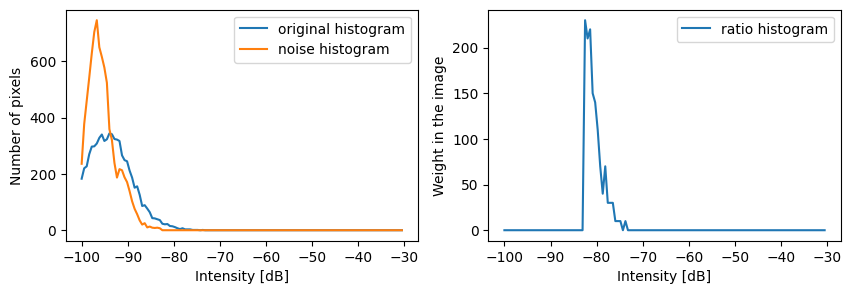

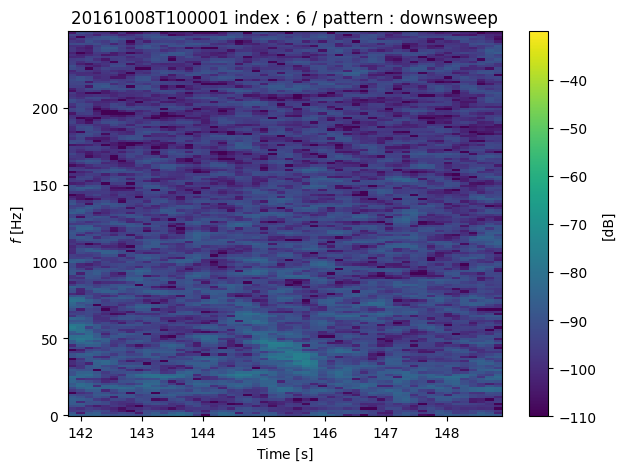

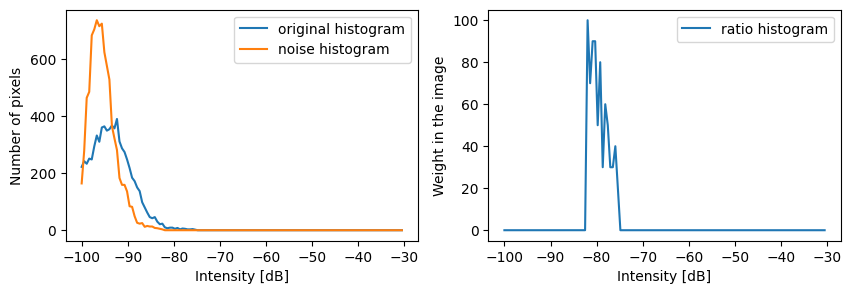

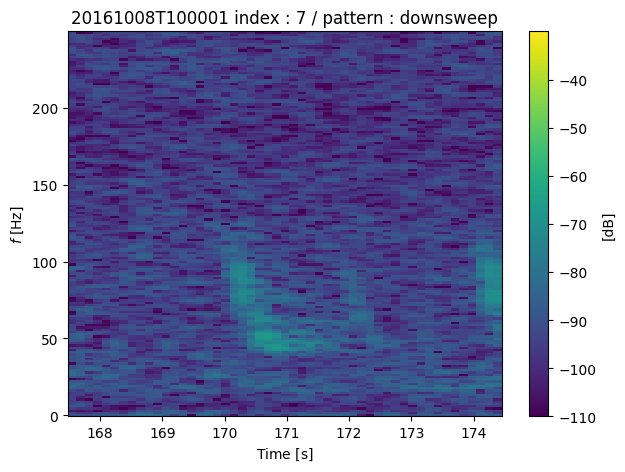

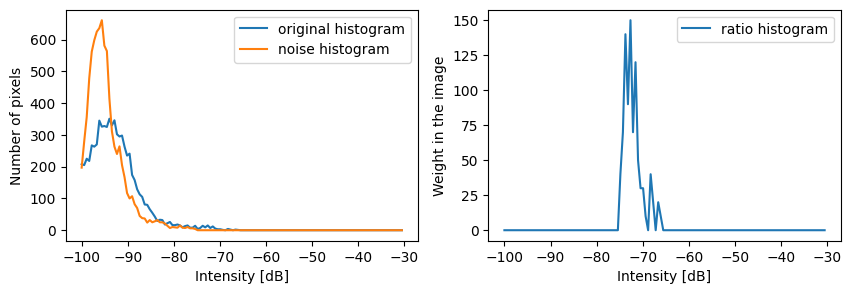

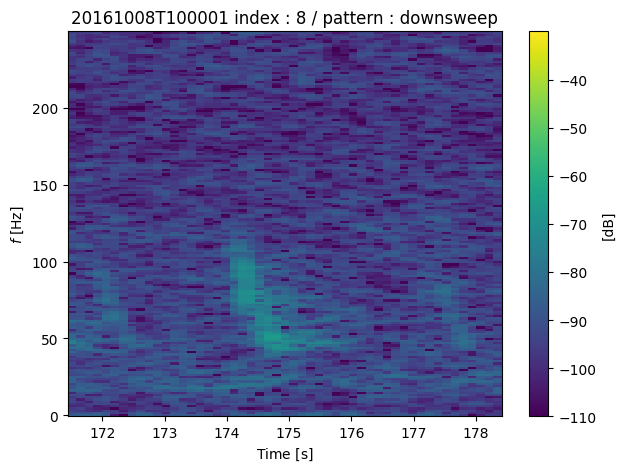

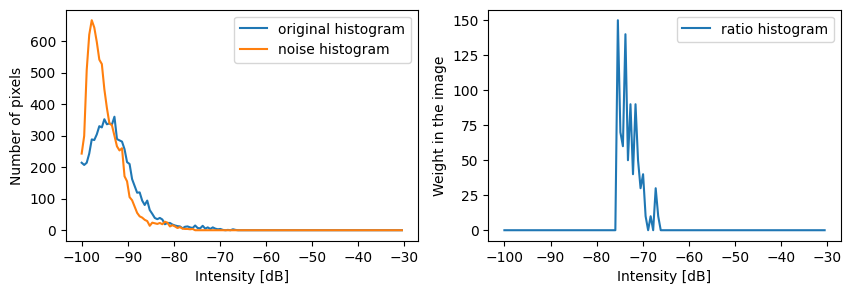

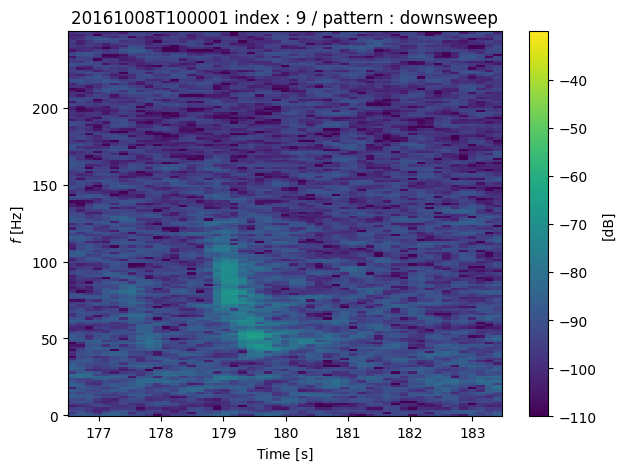

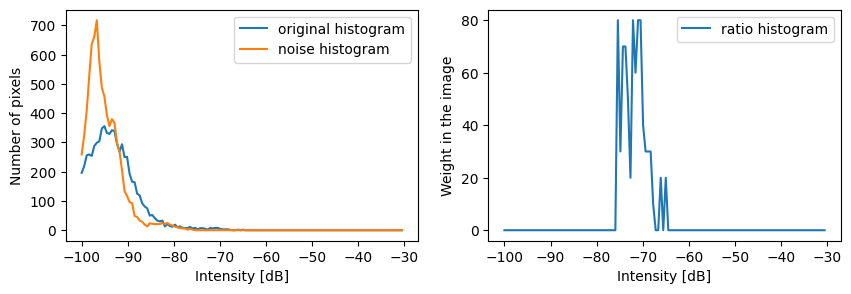

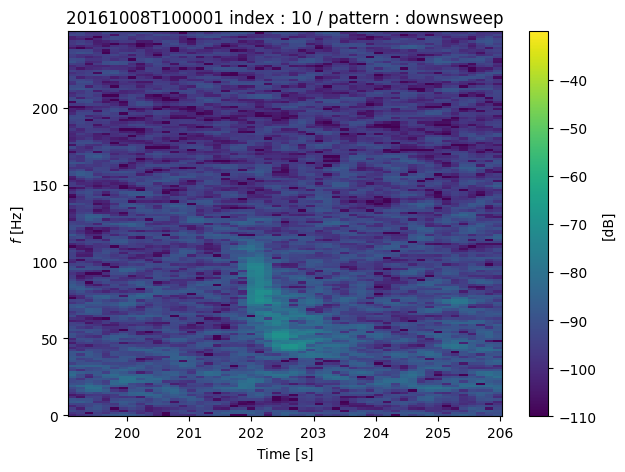

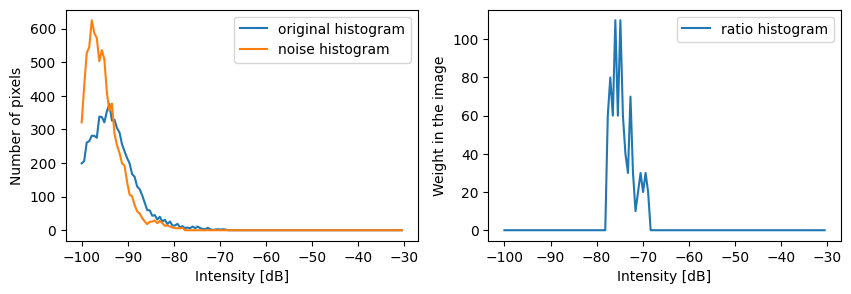

In [108]:
pointer = r'20161008T100001.txt'

dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3441'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
seuil = 150000
palier = 50

with open(str(cross_path)+'/'+pointer) as file:
    contents = file.read()
line_count = contents.count('\n')//2
list_content = contents.split('\n')
for i in range(line_count):
    f, t, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+pointer[:-3]+"nc",index= i, display= True)
    spec_aff = 20*np.log10(abs(spec))
    spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
    #plot_spectro(10**(spec_filt/20), f,t, 30, 'spectrogram '+str(i)+' filtered', [7,5])
    histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
    histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
    histogram = histogram_STA/(histogram_LTA+10e-5)
    
    plt.figure(figsize= [10,3])
    ax1 = plt.subplot(1,2,1)
    plt.plot(bins[:-1], histogram_STA)
    plt.plot(bins[:-1], histogram_LTA)
    #plt.vlines(-70, 0, 20, colors='r')
    plt.legend(['original histogram','noise histogram'])
    plt.xlabel('Intensity [dB]')
    plt.ylabel('Number of pixels')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(bins[:-1], histogram/1000)
    #plt.vlines(-70, 0, 300000, colors='r')
    plt.legend(['ratio histogram'], loc=1)
    plt.xlabel('Intensity [dB]')
    plt.ylabel('Weight in the image')
    
    plt.show()

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3441'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
month = '201610'
seuil = 150000
palier = 70

n_label = 0
n_cross = 0
n_agree = 0
for pointer in cross_names:
    if pointer in label_names:
        # extraction des données du set cross
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        cross_coords = np.zeros(line_count)
        cross_pattern = np.array([])

        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                cross_pattern = np.append(cross_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                cross_coords[i] = tmoy
                n_cross += 1
            else:
                cross_pattern = np.append(cross_pattern, None)
                cross_coords[i]=np.nan
        
        # extraction des données du set originel
        
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        label_coords = np.zeros(line_count)
        label_pattern = np.array([])

        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spectrograms/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                label_pattern = np.append(label_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                label_coords[i] = tmoy
                n_label +=1
            else:
                label_pattern = np.append(label_pattern, None)
                label_coords[i] = np.nan
        
        epsilon = 1.3

        # Find the max length
        max_len = np.max([cross_coords.size, label_coords.size])

        # Compare and collect indices where they differ
        same_pattern = np.array([])
        for i in range(max_len):
            time_cross = cross_coords[i] if i<cross_coords.size else np.nan
            time_label = label_coords[i] if i<label_coords.size else np.nan
            if abs(time_cross-time_label) < epsilon :
                same_pattern = np.append(same_pattern, (time_cross + time_label)/2)
            else :
                same_pattern = np.append(same_pattern, time_cross) if np.any(np.isclose(label_coords, time_cross, atol= epsilon)) else same_pattern
        
        cross_pattern_mask = np.array([])
        label_pattern_mask = np.array([])
        for t_pat in same_pattern : 
            cross_pattern_mask = np.append(cross_pattern_mask, cross_pattern[np.isclose(cross_coords, t_pat, atol=epsilon)])
            label_pattern_mask = np.append(label_pattern_mask, label_pattern[np.isclose(label_coords, t_pat, atol=epsilon)])
        n_agree += len(cross_pattern_mask==label_pattern_mask)

        
        f, t, spec, n_pat, _ = spec_ds(path= r"E:\3441\spec_cross\201610"+pointer[6:-3]+"nc")

        fmin, fmax = 0, 250
        tmin, tmax = 120, 270
        fmask = (f >= fmin) & (f <= fmax)
        tmask = (t >= tmin) & (t <= tmax)
        freq = np.copy(f[fmask])
        time = np.copy(t[tmask])
        spec_data = np.copy(spec[fmask,:][:,tmask])

        font = {'family' : 'sans-serif', 'size'   : 18}
        matplotlib.rc('font', **font)
        params = {"font.serif" : ["Computer Modern Serif"]}
        plt.rcParams.update(params)
        matplotlib.rc('text', usetex=False)

        matplotlib.rcParams["mathtext.fontset"]='cm'
        matplotlib.rcParams['text.usetex'] = False
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)

        fig = plt.figure(figsize=[16,4])
        im = plt.pcolormesh(time/60,freq,20*np.log10(abs(spec_data)))
        bmax = -30
        bmin = bmax - 80

        plt.xlabel(r'$\rm{Time\ [min]}$')
        plt.ylabel(r'$f\ \rm{[Hz]}$')
        plt.title(str(pointer), loc= 'center')
        
        plt.clim([bmin,bmax])
        plt.colorbar(im, label= '[dB]')
        fig.set_facecolor("white")
        plt.vlines(cross_coords/60, fmin, fmax-1, colors='r')
        plt.vlines(label_coords/60, fmin, fmax-1, colors='y')
        plt.vlines(same_pattern/60, fmin, fmax-1, colors="#00faf2", linestyles='dotted')
        plt.legend(["annotator 1", "annotator 2", "agreement"])
        plt.show()
        
    else:
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                n_cross += 1

for pointer in [name for name in label_names if name.startswith(month)]:
    if pointer not in cross_names:
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441/spectrograms/"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                n_label += 1

list_pattern = np.array([], dtype=str)  
label_count = np.array([])
for name_str in [name for name in label_names if name.startswith(month)]:
    with open(str(label_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        _, _, spec, _, _ = open_ds(path= r"E:\3441/spectrograms/"+name_str[:-3]+"nc",index= i)
        spec_aff = 20*np.log10(abs(spec))
        spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
        histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
        histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
        histogram = histogram_STA/(histogram_LTA+10e-5)
        test = np.sum(histogram[bins[:-1]>-palier])
        if test>=seuil:
            data = list_content[2*i].split()
            pattern = data[2]
            if pattern in list_pattern:
                label_count[list_pattern==pattern] += 1
            else:
                list_pattern = np.append(list_pattern, pattern)
                label_count = np.append(label_count, 1)


cross_count = np.zeros_like(list_pattern, dtype=int)
for name_str in cross_names:
    with open(str(cross_path)+'/'+name_str) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    list_content = contents.split('\n')
    for i in range(line_count):
        _, _, spec, _, _ = open_ds(path= r"E:\3441/spec_cross/"+name_str[:-3]+"nc",index= i)
        spec_aff = 20*np.log10(abs(spec))
        spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
        histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
        histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
        histogram = histogram_STA/(histogram_LTA+10e-5)
        test = np.sum(histogram[bins[:-1]>-palier])
        if test>=seuil:
            data = list_content[2*i].split()
            pattern = data[2]
            if pattern in list_pattern:
                cross_count[list_pattern==pattern] += 1
            else:
                list_pattern = np.append(list_pattern, pattern)
                cross_count = np.append(cross_count, 1)
            
n_tot = n_cross + n_label - n_agree

P0 = n_agree/n_tot
Pe = (cross_count[0]*label_count[0]+cross_count[1]*label_count[1]+(n_tot-n_cross)*(n_tot-n_label))/n_tot**2
kappa= (P0-Pe)/(1-Pe)

#print('kappa = ', round(kappa*100)/100)
print('kappa = ', kappa)
print('n_agree = ', n_agree)
print('n_tot = ', n_tot)

## Optimisation

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3441'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
month = '201610'
seuil = 100000
palier = 70

n_label = 0
n_cross = 0
n_agree = 0
list_pattern = np.array(['downsweep', 'upsweep'], dtype=str)  
label_count = np.zeros_like(list_pattern, dtype=int)
cross_count = np.zeros_like(list_pattern, dtype=int)

for pointer in cross_names:
    if pointer in label_names:
        # extraction des données du set cross
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        cross_coords = np.zeros(line_count)
        cross_pattern = np.array([])

        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441\spec_cross\\"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                cross_pattern = np.append(cross_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                cross_coords[i] = tmoy
                n_cross += 1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    cross_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    cross_count = np.append(cross_count, 1)
            else:
                cross_pattern = np.append(cross_pattern, None)
                cross_coords[i]=np.nan
        
        # extraction des données du set originel
        
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        label_coords = np.zeros(line_count)
        label_pattern = np.array([])

        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441\spectrograms\\"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                label_pattern = np.append(label_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                label_coords[i] = tmoy
                n_label +=1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    label_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    label_count = np.append(label_count, 1)
            else:
                label_pattern = np.append(label_pattern, None)
                label_coords[i] = np.nan
        
        epsilon = 1.3

        # Find the max length
        max_len = np.max([cross_coords.size, label_coords.size])

        # Compare and collect indices where they differ
        same_pattern = np.array([])
        for i in range(max_len):
            time_cross = cross_coords[i] if i<cross_coords.size else np.nan
            time_label = label_coords[i] if i<label_coords.size else np.nan
            if abs(time_cross-time_label) < epsilon :
                same_pattern = np.append(same_pattern, (time_cross + time_label)/2)
            else :
                same_pattern = np.append(same_pattern, time_cross) if np.any(np.isclose(label_coords, time_cross, atol= epsilon)) else same_pattern
        
        cross_pattern_mask = np.array([])
        label_pattern_mask = np.array([])
        for t_pat in same_pattern : 
            cross_pattern_mask = np.append(cross_pattern_mask, cross_pattern[np.isclose(cross_coords, t_pat, atol=epsilon)])
            label_pattern_mask = np.append(label_pattern_mask, label_pattern[np.isclose(label_coords, t_pat, atol=epsilon)])
        n_agree += len(cross_pattern_mask==label_pattern_mask)

        
        f, t, spec, n_pat, _ = spec_ds(path= r"E:\3441\spec_cross\201610"+pointer[6:-3]+"nc")

        fmin, fmax = 0, 250
        tmin, tmax = 120, 270
        fmask = (f >= fmin) & (f <= fmax)
        tmask = (t >= tmin) & (t <= tmax)
        freq = np.copy(f[fmask])
        time = np.copy(t[tmask])
        spec_data = np.copy(spec[fmask,:][:,tmask])

        font = {'family' : 'sans-serif', 'size'   : 18}
        matplotlib.rc('font', **font)
        params = {"font.serif" : ["Computer Modern Serif"]}
        plt.rcParams.update(params)
        matplotlib.rc('text', usetex=False)

        matplotlib.rcParams["mathtext.fontset"]='cm'
        matplotlib.rcParams['text.usetex'] = False
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)

        fig = plt.figure(figsize=[16,4])
        im = plt.pcolormesh(time/60,freq,20*np.log10(abs(spec_data)))
        bmax = -30
        bmin = bmax - 80

        plt.xlabel(r'$\rm{Time\ [min]}$')
        plt.ylabel(r'$f\ \rm{[Hz]}$')
        plt.title(str(pointer), loc= 'center')
        
        plt.clim([bmin,bmax])
        plt.colorbar(im, label= '[dB]')
        fig.set_facecolor("white")
        plt.vlines(cross_coords/60, fmin, fmax-1, colors='r')
        plt.vlines(label_coords/60, fmin, fmax-1, colors='y')
        plt.vlines(same_pattern/60, fmin, fmax-1, colors="#00faf2", linestyles='dotted')
        plt.legend(["annotator 1", "annotator 2", "agreement"])
        plt.show()
        
    else:
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441\spec_cross\\"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                n_cross += 1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    cross_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    cross_count = np.append(cross_count, 1)

for pointer in [name for name in label_names if name.startswith(month)]:
    if pointer not in cross_names:
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            _, _, spec, _, _ = open_ds(path= r"E:\3441\spectrograms\\"+pointer[:-3]+"nc",index= i)
            spec_aff = 20*np.log10(abs(spec))
            spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
            histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
            histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
            histogram = histogram_STA/(histogram_LTA+10e-5)
            test = np.sum(histogram[bins[:-1]>-palier])
            if test>=seuil:
                n_label += 1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    label_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    label_count = np.append(label_count, 1)

          
n_tot = n_cross + n_label - n_agree

P0 = n_agree/n_tot
Pe = (cross_count[0]*label_count[0]+cross_count[1]*label_count[1]+(n_tot-n_cross)*(n_tot-n_label))/n_tot**2
kappa= (P0-Pe)/(1-Pe)

#print('kappa = ', round(kappa*100)/100)
print('kappa = ', kappa)
print('n_agree = ', n_agree)
print('n_tot = ', n_tot)

In [ ]:
dataset_path = r'C:\Users\noesc\Desktop\PFE\data\3441'
cross_path = Path(dataset_path + r'\label_cross')
cross_names = [f.name for f in cross_path.iterdir() if f.is_file()]
label_path = Path(dataset_path + r'\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
month = '201610'
seuil = -1.67

n_label = 0
n_cross = 0
n_agree = 0
list_pattern = np.array(['downsweep', 'upsweep'], dtype=str)  
label_count = np.zeros_like(list_pattern, dtype=int)
cross_count = np.zeros_like(list_pattern, dtype=int)

for pointer in cross_names:
    if pointer in label_names:
        # extraction des données du set cross
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        cross_coords = np.zeros(line_count)
        cross_pattern = np.array([])

        for i in range(line_count):
            freq, _, spec, _, _ = open_ds(path= r"E:\3441\spec_cross\\"+pointer[:-3]+"nc",index= i)
            fmask = (freq >= 20) & (freq <= 200)
            spec_aff = 20*np.log10(abs(spec[fmask,:]))
            thresh = np.percentile(spec_aff, 95)  # top 5% brightest pixels = signal
            signal_mask = spec_aff > thresh
            noise_mask = ~signal_mask

            # --- Compute power in signal and noise ---
            signal_power = np.mean(spec_aff[signal_mask] ** 2)
            noise_power = np.mean(spec_aff[noise_mask] ** 2)

            # --- Compute SNR in dB ---
            snr_db = 10 * np.log10(signal_power / noise_power)
            if snr_db<=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                cross_pattern = np.append(cross_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                cross_coords[i] = tmoy
                n_cross += 1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    cross_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    cross_count = np.append(cross_count, 1)
            else:
                cross_pattern = np.append(cross_pattern, None)
                cross_coords[i]=np.nan
        
        # extraction des données du set originel
        
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        
        label_coords = np.zeros(line_count)
        label_pattern = np.array([])

        for i in range(line_count):
            freq, _, spec, _, _ = open_ds(path= r"E:\3441\spectrograms\\"+pointer[:-3]+"nc",index= i)
            fmask = (freq >= 20) & (freq <= 200)
            spec_aff = 20*np.log10(abs(spec[fmask,:]))
            thresh = np.percentile(spec_aff, 95)  # top 5% brightest pixels = signal
            signal_mask = spec_aff > thresh
            noise_mask = ~signal_mask

            # --- Compute power in signal and noise ---
            signal_power = np.mean(spec_aff[signal_mask] ** 2)
            noise_power = np.mean(spec_aff[noise_mask] ** 2)

            # --- Compute SNR in dB ---
            snr_db = 10 * np.log10(signal_power / noise_power)
            if snr_db<=seuil:
                delta_time = list_content[2*i].split()
                delta_freq = list_content[2*i+1][3:].split()

                label_pattern = np.append(label_pattern, delta_time[2])
                tmin, tmax = float(delta_time[0]), float(delta_time[1])
                tmoy = (tmin + tmax)/2
                label_coords[i] = tmoy
                n_label +=1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    label_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    label_count = np.append(label_count, 1)
            else:
                label_pattern = np.append(label_pattern, None)
                label_coords[i] = np.nan
        
        epsilon = 1.3

        # Find the max length
        max_len = np.max([cross_coords.size, label_coords.size])

        # Compare and collect indices where they differ
        same_pattern = np.array([])
        for i in range(max_len):
            time_cross = cross_coords[i] if i<cross_coords.size else np.nan
            time_label = label_coords[i] if i<label_coords.size else np.nan
            if abs(time_cross-time_label) < epsilon :
                same_pattern = np.append(same_pattern, (time_cross + time_label)/2)
            else :
                same_pattern = np.append(same_pattern, time_cross) if np.any(np.isclose(label_coords, time_cross, atol= epsilon)) else same_pattern
        
        cross_pattern_mask = np.array([])
        label_pattern_mask = np.array([])
        for t_pat in same_pattern : 
            cross_pattern_mask = np.append(cross_pattern_mask, cross_pattern[np.isclose(cross_coords, t_pat, atol=epsilon)])
            label_pattern_mask = np.append(label_pattern_mask, label_pattern[np.isclose(label_coords, t_pat, atol=epsilon)])
        n_agree += len(cross_pattern_mask==label_pattern_mask)
        
    else:
        with open(str(cross_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            freq, _, spec, _, _ = open_ds(path= r"E:\3441\spec_cross\\"+pointer[:-3]+"nc",index= i)
            fmask = (freq >= 20) & (freq <= 200)
            spec_aff = 20*np.log10(abs(spec[fmask,:]))
            thresh = np.percentile(spec_aff, 95)  # top 5% brightest pixels = signal
            signal_mask = spec_aff > thresh
            noise_mask = ~signal_mask

            # --- Compute power in signal and noise ---
            signal_power = np.mean(spec_aff[signal_mask] ** 2)
            noise_power = np.mean(spec_aff[noise_mask] ** 2)

            # --- Compute SNR in dB ---
            snr_db = 10 * np.log10(signal_power / noise_power)
            if snr_db<=seuil:
                n_cross += 1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    cross_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    cross_count = np.append(cross_count, 1)

for pointer in [name for name in label_names if name.startswith(month)]:
    if pointer not in cross_names:
        with open(str(label_path)+'/'+pointer) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        for i in range(line_count):
            freq, _, spec, _, _ = open_ds(path= r"E:\3441\spectrograms\\"+pointer[:-3]+"nc",index= i)
            fmask = (freq >= 20) & (freq <= 200)
            spec_aff = 20*np.log10(abs(spec[fmask,:]))
            thresh = np.percentile(spec_aff, 95)  # top 5% brightest pixels = signal
            signal_mask = spec_aff > thresh
            noise_mask = ~signal_mask

            # --- Compute power in signal and noise ---
            signal_power = np.mean(spec_aff[signal_mask] ** 2)
            noise_power = np.mean(spec_aff[noise_mask] ** 2)

            # --- Compute SNR in dB ---
            snr_db = 10 * np.log10(signal_power / noise_power)
            if snr_db<=seuil:
                n_label += 1
                
                pattern = delta_time[2]
                if pattern in list_pattern:
                    label_count[list_pattern==pattern] += 1
                else:
                    list_pattern = np.append(list_pattern, pattern)
                    label_count = np.append(label_count, 1)

          
n_tot = n_cross + n_label - n_agree

P0 = n_agree/n_tot
Pe = (cross_count[0]*label_count[0]+cross_count[1]*label_count[1]+(n_tot-n_cross)*(n_tot-n_label))/n_tot**2
kappa= (P0-Pe)/(1-Pe)

#print('kappa = ', round(kappa*100)/100)
print('kappa = ', kappa)
print('n_agree = ', n_agree)
print('n_tot = ', n_tot)

In [ ]:
label_path = Path(r'C:\Users\noesc\Desktop\PFE\data\3441\label_cross')
label_names = [f.name for f in cross_path.iterdir() if f.is_file()]
month = '201610'
palier = 70

snr_result = []
sta_result = []

for pointer in label_names:
    with open(str(label_path)+'/'+pointer) as file:
        contents = file.read()
    line_count = contents.count('\n')//2
    for i in range(line_count):
        _, _, spec, _, _ = open_ds(path= r"E:\3441\spec_cross\\"+pointer[:-3]+"nc",index= i)
        spec_aff = 20*np.log10(abs(spec))
        thresh = np.percentile(spec_aff, 95)  # top 5% brightest pixels = signal
        signal_mask = spec_aff > thresh
        noise_mask = ~signal_mask

        # --- Compute power in signal and noise ---
        signal_power = np.mean(spec_aff[signal_mask] ** 2)
        noise_power = np.mean(spec_aff[noise_mask] ** 2)

        # --- Compute SNR in dB ---
        snr_db = 10 * np.log10(signal_power / noise_power)
        
        snr_result.append(snr_db)
        
        spec_filt = sc.ndimage.gaussian_filter(spec_aff,2)
        histogram_STA, bins = np.histogram(spec_aff, bins= 128, range= (-100,-30))
        histogram_LTA, _ = np.histogram(spec_filt, bins= 128, range= (-100,-30))
        histogram = histogram_STA/(histogram_LTA+10e-5)
        test = np.sum(histogram[bins[:-1]>-palier])
        
        sta_result.append(test)

In [ ]:
n_agree = 0
seuil_snr = -1.67
seuil = 150000

for i in range(len(sta_result)):
    if sta_result[i] >= seuil and snr_result[i] <= seuil_snr :
        n_agree += 1


print(sum(np.array(sta_result)>=seuil), sum(np.array(snr_result)<=seuil_snr), n_agree)
print(n_agree/sum(np.array(sta_result)>=seuil), n_agree/sum(np.array(snr_result)<=seuil))

# Noise Dataset

In [ ]:
label_path = Path(r'C:\Users\noesc\Desktop\PFE\data\3446')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
audio_path = Path(r'D:\Gregoire_Malo\3446\flac\flac')
#audio_names = [f.name for f in audio_path.iterdir() if f.is_file()]

audio, fs = sf.read(r'D:\Gregoire_Malo\3446\flac\flac\20160227T020000.flac')

n_fft = 4096
hop_length = n_fft*0.5
f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)

fmin, fmax = 0, 250
tmin, tmax = t[0], t[-1]
fmask = (f >= fmin) & (f <= fmax)
tmask = (t >= tmin) & (t <= tmax)
fslice = np.copy(f[fmask])
tslice = np.copy(t[tmask])
spec_data = np.copy(spectro[fmask,:][:,tmask])

plot_spectro(spec= spec_data, freq= fslice, time= tslice, gain= 20, title= "spectrogramme ")



In [ ]:
with open("20160227T020000.txt", "x") as label:
  label.write("60 60 noise\n"+
              "\\ "+str(fmin)+" "+str(fmax)+"\n"+
              "150 150 noise\n"+
              "\\ "+str(fmin)+" "+str(fmax)+"\n"+
              "240 240 noise\n"+
              "\\ "+str(fmin)+" "+str(fmax)+"\n")

In [ ]:
ds = build_ds(full_spec= spectro, freq= f, time= t, label_path= '20160227T020000.txt')
ds.to_netcdf('20160227T020000.nc')

for i in range(ds.index.size):
    open_ds(path='20160227T020000.nc',index= i, display=True)

In [ ]:
label_path = Path(r'C:\Users\noesc\Desktop\PFE\data\3446\labels')
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
audio_path = Path(r'D:\Gregoire_Malo\3446\flac\flac')
audio_names = [f.name for f in audio_path.iterdir() if f.is_file()]

In [ ]:
audio_dir = audio_names[::20]
n_fft = 4096
hop_length = n_fft*0.2
fmin, fmax = 0, 250


def work(audio_name):
    label_name = audio_name[:-4]+'txt'
    if label_name not in label_names:
        
        audio, fs = sf.read(str(audio_path)+'/'+audio_name)
        f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)
        
        with open(r'C:\Users\noesc\Desktop\PFE\data\3446\label_noise'+'/'+label_name, "x") as label:
            label.write("60 60 noise\n"+
                        "\\ "+str(fmin)+" "+str(fmax)+"\n"+
                        "150 150 noise\n"+
                        "\\ "+str(fmin)+" "+str(fmax)+"\n"+
                        "240 240 noise\n"+
                        "\\ "+str(fmin)+" "+str(fmax)+"\n")
        
        ds = build_ds(full_spec= spectro, freq= f, time= t, label_path= r'C:\Users\noesc\Desktop\PFE\data\3446\label_noise'+'/'+label_name)
        ds.to_netcdf(r'D:\Gregoire_Malo\3446\flac\noise\\' + audio_name[:-4]+'nc')
    return

with ThreadPoolExecutor() as executor:
   executor.map(work, audio_dir)
        

In [ ]:
ds_path = Path(r'D:\Gregoire_Malo\3446\flac\noise')
ds_dir = [f.name for f in ds_path.iterdir() if f.is_file()]
ds_names = ds_dir[:10]

for ds_name in ds_names:
    print(ds_name)
    ds = xr.open_dataset(str(ds_path)+'/'+ds_name)
    for i in range(ds.index.size):
        _,t,_,_,_ = open_ds(path=str(ds_path)+'/'+ds_name,index= i, display=True)
        print(t.size)

# Data Augmentation

## Photometric variations

In [ ]:
data_path = Path(r"C:\Users\noesc\Desktop\PFE\data\data_aug\regular_png")  # adjust this path

# Collect file names in a list
file_names = [f.name for f in data_path.iterdir() if f.is_file()]

for f in file_names:
    im = cv2.imread(str(data_path) + '/' + f)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(str(data_path) + '/' + f, gray)

In [ ]:
data_path = Path(r"C:\Users\noesc\Desktop\PFE\data\data_aug\regular_png")  # adjust this path

# Collect file names in a list
file_names = [f.name for f in data_path.iterdir() if f.is_file()]

filters = ['light', 'noise', 'contrast', 'blur', 'flip']

i = 0 #light
im = cv2.imread(str(data_path)+'/'+file_names[i], cv2.IMREAD_GRAYSCALE)
for k in [-10,-5,5,10,15,20]:
    cv2.imwrite(r"C:\Users\noesc\Desktop\PFE\data\data_aug\edited\light"+str(k).zfill(2)+'.png', im+float(k))

i = 1 #noise
im = cv2.imread(str(data_path)+'/'+file_names[i], cv2.IMREAD_GRAYSCALE)
for k in [10,20,30,40,50]:
    gauss = np.zeros_like(im, dtype=np.uint8)
    cv2.randn(gauss, 0, k)
    cv2.imwrite(r"C:\Users\noesc\Desktop\PFE\data\data_aug\edited\noise"+str(k).zfill(3)+'.png', cv2.add(im, gauss))

i = 2 #contrast
im = cv2.imread(str(data_path)+'/'+file_names[i], cv2.IMREAD_GRAYSCALE)
for k in [0.6,0.8,1.2,1.4,1.6]:
    cv2.imwrite(r"C:\Users\noesc\Desktop\PFE\data\data_aug\edited\cont"+str(int(100*k)).zfill(2)+'.png', im*float(k))
    
i = 3 #blur
im = cv2.imread(str(data_path)+'/'+file_names[i], cv2.IMREAD_GRAYSCALE)
for k in [3,5,7,9,11]:
    cv2.imwrite(r"C:\Users\noesc\Desktop\PFE\data\data_aug\edited\blur"+str(k).zfill(2)+'.png', cv2.blur(im,(k,k)))

i = 4 #flip
im = cv2.imread(str(data_path)+'/'+file_names[i], cv2.IMREAD_GRAYSCALE)
cv2.imwrite(r"C:\Users\noesc\Desktop\PFE\data\data_aug\edited\flip.png", cv2.flip(im,1))


In [ ]:
data_path = Path(r"E:\data_set_training_all\upsweep\upsweep_3441")  # adjust this path

# Collect file names in a list
file_names = [f.name for f in data_path.iterdir() if f.is_file()]

for f in file_names:
    for k in range(4):
        im = cv2.imread(str(data_path)+'/'+f, cv2.IMREAD_GRAYSCALE)
        
        filters = [np.random.randint(-10,10),
                   np.random.randint(0,20),
                   np.random.randint(60,110),
                   np.random.rand(),
                   np.random.rand()]
        
        im = cv2.convertScaleAbs(im, beta= filters[0])
        
        gauss = np.zeros_like(im, dtype=np.uint8)
        cv2.randn(gauss, 0, filters[1])
        im = cv2.add(im, gauss)
        
        im = cv2.convertScaleAbs(im, alpha= filters[2]/100)
        
        im = cv2.blur(im,(3,3)) if filters[3] < 0.2 else im
        
        #im = cv2.flip(im,1) if filters[4] < 0.2 else im
        
        cv2.imwrite(r"C:\Users\noesc\Desktop\PFE\data\data_aug\photo\\"+f[:-4]+str(k)+".png", im)
        

## Second method

In [ ]:
data_path = Path(r"D:\3501_data\upsweep")  # adjust this path

# Collect file names in a list
file_names = [f.name for f in data_path.iterdir() if f.is_file()]

for _ in range(5000): 
    a, b = random.sample(file_names, 2)

    im1 = cv2.imread(str(data_path)+'/'+a, cv2.IMREAD_GRAYSCALE)
    im2 = cv2.imread(str(data_path)+'/'+b, cv2.IMREAD_GRAYSCALE)

    out = np.resize(im1//2,(171,51)) + np.resize(im2//2,(171,51))

    cv2.imwrite(r"D:\3501_data\upsweep_augmented\\"+a[6:-4]+'-'+b[6:-4]+'.png', out)

# make .png files

## turn .nc to .png

In [ ]:
data_path = Path(r"")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]

M, m = -30,-110

def work(file_name):
    ds = xr.open_dataset(str(data_path) + '/' + file_name)
    for i in range(ds.index.size):
        _, _, spec, p, _ = open_ds(str(data_path)+'/'+file_name, index=i)
        if snr_test(spec, limit = -50):
            tab = 20*np.log10(np.abs(spec))
            tab = np.flipud(tab)
            tab = (tab-m)*255/(M-m)
            if p == 'downsweep':
                cv2.imwrite()
    return

with ThreadPoolExecutor() as exec:
    exec.map(work, data_names)

## turn .flac to .png

In [ ]:
data_path = Path(r"")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]


def work(file_name):
    audio, fs = sf.read(str(data_path)+ '/'+ file_name)
    
    n_fft = 4096
    hop_length = n_fft*0.2
    _, _, spec = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)
    
    tab = 20*np.log10(np.abs(spec))
    tab = np.flipud(tab)
    tab = (tab-m)*255/(M-m)

    cv2.imwrite()

with ThreadPoolExecutor() as executor:
    executor.map(work, data_names)

# shape matching for tonal detection

## create average tonal shape

In [ ]:
data_path = Path(r"D:\tonal\tonal_3446")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]

tonal = cv2.imread(str(data_path) + '/' + data_names[0], cv2.IMREAD_GRAYSCALE)
tonal = np.resize(tonal, (171,51)).astype(int)

for data_file in data_names:
    img1 = cv2.imread(str(data_path) + '/' + data_file, cv2.IMREAD_GRAYSCALE)
    tonal += np.resize(img1,(171,51)).astype(int)

out = tonal//len(data_names)
out = out*float(0.8)
cv2.imwrite(r"D:\tonal\average_tonal.png", out.astype(np.uint8))

# Find this pattern in spectrograms

In [ ]:
data_path = Path(r"D:\Gregoire_Malo\3446\flac\flac")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]
file_names = np.copy([name for name in data_names if name.startswith('20170212T0645')])

In [ ]:
M, m = -30,-110
fmin, fmax = 0,250

tonal = cv2.imread(r"D:\tonal\average_tonal.png", cv2.IMREAD_GRAYSCALE)
contours_tonal, _ = cv2.findContours(cv2.threshold(tonal, 127, 255, 0)[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#affichage
cnt_tonal = np.zeros_like(tonal)
cv2.drawContours(cnt_tonal, [contours_tonal[2]], -1, 255, thickness=1)
plt.imshow(cnt_tonal, cmap="gray")
plt.axis("off")
plt.show()
print(cv2.contourArea(contours_tonal[2]))

for file_name in file_names:
    audio, fs = sf.read(str(data_path)+ '/'+ file_name)
    
    n_fft = 4096
    hop_length = n_fft*0.2
    f, t, spec = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)
    fmask = (f >= fmin) & (f <= fmax)
    tmask = (t >= 0)

    fslice = np.full_like(f, np.nan)
    fslice[np.ix_(fmask)] = np.copy(f[np.ix_(fmask)])
    fslice = fslice[~np.isnan(fslice)]

    spec_data = np.full_like(spec, np.nan)
    spec_data[np.ix_(fmask, tmask)] = np.copy(spec[np.ix_(fmask, tmask)])
    spec_data = spec_data[~np.isnan(spec_data)].reshape(fslice.size, t.size)
    
    plot_spectro(spec_data, fslice, t, gain=20, title= file_name)
    
    tab = 20*np.log10(np.abs(spec_data))
    tab = np.flipud(tab)
    tab = (tab-m)*255/(M-m)
    tab = tab.astype(np.uint8) # cv2.blur(tab,(3,3))
    
    contours_spec, _ = cv2.findContours(cv2.threshold(tab, 150, 255, 0)[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    '''contours = []
    for cnt in contours_spec:
        if (cv2.contourArea(cnt) > 10) & (cv2.contourArea(cnt) < 1000):
            contours.append(cnt)'''
    print(len(contours_spec))
    
    
    for cnt in contours_spec:
        similarity = cv2.matchShapes(contours_tonal[2], cnt, cv2.CONTOURS_MATCH_I1, 0.0)
        if similarity<10:
            blank = np.zeros_like(tab)
            cv2.drawContours(blank, [cnt], -1, 255, thickness=1)
            #plt.Figure(figsize=[10,2])
            plt.imshow(blank, cmap="gray", aspect=2)
            plt.axis("off")
            plt.show()
        leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
        x_left = t[leftmost[0]]/60
        print(similarity, cv2.contourArea(cnt), x_left)

Result : method not working : too sensitive to noise

## spectrogram correlation : Sum of squared difference

In [121]:
data_path = Path(r"D:\Gregoire_Malo\3334\flac")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]

'''data_path = Path(r"E:\3381\flac")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]
file_names = data_names[31647:]'''
fmin, fmax = 0,250

tonal_template = cv2.imread(r"C:\Users\noesc\Desktop\PFE\data\average_tonal.png", cv2.IMREAD_GRAYSCALE)
#tonal_template = cv2.imread(r"D:\tonal\tonal_3446\20170212T064500.png", cv2.IMREAD_GRAYSCALE)
canny_tonal = cv2.Canny(tonal_template, 20, 50)
sobel_tonal = cv2.Sobel(tonal_template, cv2.CV_64F, dx=0, dy=1, ksize=3)
sobel_tonal = cv2.convertScaleAbs(sobel_tonal)
sobel_tonal[165:] = 0
sobel_tonal[sobel_tonal<50] = 0
sobel_tonal = (cv2.blur(sobel_tonal,(3,5)))
sobel_tonal[:] = sobel_tonal[:] * 2
sobel_tonal = cv2.dilate(sobel_tonal, kernel= np.ones((3,3))*0.5)


'''plt.subplot(1,2,1)
plt.imshow(tonal_template, cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(sobel_tonal, cmap="gray")
plt.axis("off")
plt.show()'''


for file_name in data_names:
    audio, fs = sf.read(str(data_path)+ '/'+ file_name)
    
    n_fft = 4096
    hop_length = n_fft*0.2
    f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)
    fmask = (f >= fmin) & (f <= fmax)
    tmask = (t >= 0)

    fslice = np.full_like(f, np.nan)
    fslice[np.ix_(fmask)] = np.copy(f[np.ix_(fmask)])
    fslice = fslice[~np.isnan(fslice)]

    spec_data = np.full_like(spectro, np.nan)
    spec_data[np.ix_(fmask, tmask)] = np.copy(spectro[np.ix_(fmask, tmask)])
    spec_data = spec_data[~np.isnan(spec_data)].reshape(fslice.size, t.size)
    
    spec_img = 20*np.log10(np.abs(spec_data))
    spec_img = (spec_img.astype(np.float32) - spec_img.mean()) / (spec_img.std() + 1e-5)
    spec_img = np.flipud(spec_img)
    spec_img[165:171] = spec_img[159:165]
    spec_img = cv2.normalize(spec_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    spec = (cv2.blur(spec_img,(3,3)))
    sobel_spec = cv2.Sobel(spec, cv2.CV_64F, dx=0, dy=1, ksize=3)
    sobel_spec = cv2.convertScaleAbs(sobel_spec)
    sobel_spec = (cv2.blur(sobel_spec*1.5,(3,3))).astype(np.uint8)
    spec[sobel_spec<110] = 0
    spec = (cv2.blur(spec,(9,3)))
    
    
    res = cv2.matchTemplate(spec, sobel_tonal, cv2.TM_SQDIFF) # mask=sobel_tonal
    
    h, w = sobel_tonal.shape

    indices = np.argsort(res.ravel())[::-1]
    ys, xs = np.unravel_index(indices, res.shape)
    boxes = [(int(x), int(y), int(w), int(h)) for (x, y) in zip(xs, ys)]
    scores = [float(1e6/res[y, x]) for (x, y) in zip(xs, ys)]
    
    
    score_threshold = 0.46   # only consider boxes above this score
    nms_threshold = 0.0    # overlap threshold for suppression (IoU)

    indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold, nms_threshold)
    
    if len(indices) != 0 :
        picked_boxes = [boxes[i] for i in indices]
        picked_scores = [scores[i] for i in indices]
        #plot_spectro(spec_data, fslice, t, gain=30, title= file_name)
        print(picked_boxes)
        print(picked_scores)
        
        result_img = cv2.cvtColor(spec, cv2.COLOR_GRAY2BGR)
        for (x, y, _, _) in picked_boxes:
            out = np.copy(spec_img[y : y+h, x : x+w ])
            cv2.imwrite(r"D:\Gregoire_Malo\3334\tonal\\"+file_name[:-7]+str(int(t[x]/10)).zfill(2)+'.png', (out*0.7).astype(np.uint8))
            #cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

        '''plt.imshow(result_img[:,:,::-1], aspect=2)
        plt.axis("on")
        plt.xticks([0, 439, 878, 1317, 1758, 2196], ["0", "1", "2", "3", "4", "5"])
        plt.yticks([34,102, 171], ["200", "100", "0"])
        plt.show()'''


[(55, 0, 51, 171)]
[0.47460687160491943]
[(986, 0, 51, 171)]
[0.5681218504905701]
[(544, 0, 51, 171)]
[0.4742361605167389]
[(1786, 0, 51, 171)]
[0.4608953297138214]
[(2103, 0, 51, 171)]
[0.4753028452396393]
[(1529, 0, 51, 171)]
[0.4850667417049408]
[(1447, 0, 51, 171)]
[0.500103771686554]
[(842, 0, 51, 171), (1739, 0, 51, 171), (748, 0, 51, 171)]
[0.48317113518714905, 0.4657253921031952, 0.4646453559398651]
[(1629, 0, 51, 171)]
[0.5809266567230225]
[(211, 0, 51, 171)]
[0.5058180689811707]


C:\Users\noesc\AppData\Local\Temp\ipykernel_41524\2402658372.py:47: RuntimeWarning: divide by zero encountered in log10
  spec_img = 20*np.log10(np.abs(spec_data))
C:\Users\noesc\AppData\Local\Temp\ipykernel_41524\2402658372.py:48: RuntimeWarning: invalid value encountered in subtract
  spec_img = (spec_img.astype(np.float32) - spec_img.mean()) / (spec_img.std() + 1e-5)
c:\Users\noesc\Desktop\PFE\venv\Lib\site-packages\numpy\_core\_methods.py:190: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\noesc\AppData\Local\Temp\ipykernel_41524\2402658372.py:51: RuntimeWarning: invalid value encountered in cast
  spec_img = cv2.normalize(spec_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


[(1154, 0, 51, 171)]
[0.46735262870788574]
[(97, 0, 51, 171)]
[0.4720710813999176]
[(604, 0, 51, 171)]
[0.5178618431091309]
[(1775, 0, 51, 171)]
[0.4838610589504242]
[(1670, 0, 51, 171), (1144, 0, 51, 171)]
[0.4799049496650696, 0.4629666209220886]
[(450, 0, 51, 171)]
[0.5012446045875549]
[(956, 0, 51, 171)]
[0.4845568835735321]
[(1503, 0, 51, 171)]
[0.5444663166999817]
[(1673, 0, 51, 171)]
[0.5200013518333435]
[(678, 0, 51, 171)]
[0.49854400753974915]
[(1679, 0, 51, 171)]
[0.5219535231590271]
[(953, 0, 51, 171)]
[0.4721885621547699]
[(996, 0, 51, 171)]
[0.5511569976806641]
[(568, 0, 51, 171), (749, 0, 51, 171), (278, 0, 51, 171)]
[0.5980017185211182, 0.538709819316864, 0.4699457883834839]
[(782, 0, 51, 171)]
[0.502307116985321]
[(1298, 0, 51, 171), (1764, 0, 51, 171), (1439, 0, 51, 171)]
[0.5040594339370728, 0.49320536851882935, 0.4646036922931671]
[(1858, 0, 51, 171)]
[0.4678276777267456]
[(1154, 0, 51, 171)]
[0.5656448006629944]
[(425, 0, 51, 171)]
[0.49931544065475464]
[(1495, 0, 51

LibsndfileError: Error opening 'D:\\Gregoire_Malo\\3334\\flac/20150529T114500.flac': Format not recognised.

In [ ]:
tonal_template = cv2.imread(r"D:\tonal\average_tonal.png", cv2.IMREAD_GRAYSCALE)
canny_tonal = cv2.Canny(tonal_template, 20, 50)
sobel_tonal = cv2.Sobel(tonal_template, cv2.CV_64F, dx=0, dy=1, ksize=3)
sobel_tonal = cv2.convertScaleAbs(sobel_tonal)
sobel_tonal[165:] = 0
sobel_tonal[sobel_tonal<50]=0
sobel_tonal = (cv2.blur(sobel_tonal,(3,5)))
sobel_tonal[:] = sobel_tonal[:] * 2
sobel_tonal = cv2.dilate(sobel_tonal, kernel= np.ones((3,3))*0.5)
print(np.max(sobel_tonal))

h, w = sobel_tonal.shape

spec = cv2.imread(r"D:\tonal\tonal_3446\20170212T103000.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(spec, cmap="gray")
plt.axis("off")
plt.show()
spec = (cv2.blur(spec,(3,3)))
sobel_spec = cv2.Sobel(spec, cv2.CV_64F, dx=0, dy=1, ksize=3)
sobel_spec = cv2.convertScaleAbs(sobel_spec)*1.5
sobel_spec = (cv2.blur(sobel_spec,(3,3)))
spec[sobel_spec<110]=0
spec[165:] = 0
spec = (cv2.blur(spec,(5,3)))

res = cv2.matchTemplate(spec, sobel_tonal, cv2.TM_SQDIFF, mask=sobel_tonal)

indices = np.argsort(res.ravel())[:]
ys, xs = np.unravel_index(indices, res.shape)
boxes = [(int(x), int(y), int(w), int(h)) for (x, y) in zip(xs, ys)]
scores = [float(1e6/res[y, x]) for (x, y) in zip(xs, ys)]

score_threshold = 0  # only consider boxes above this score
nms_threshold = 0.01    # overlap threshold for suppression (IoU)

indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold, nms_threshold)

if len(indices) != 0 :
    picked_boxes = [boxes[i] for i in indices]
    picked_scores = [scores[i] for i in indices]
    print(picked_scores)
else:
    print('0.0')

plt.subplot(1,3,1)
plt.imshow(sobel_tonal, cmap="gray")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(spec, cmap="gray")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(sobel_spec, cmap="gray")
plt.axis("off")
plt.show()

# Precision-recall curve

In [57]:
data_path = Path(r"E:\3381\flac")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]
label_path = Path(r"C:\Users\noesc\Desktop\PFE\data\3381\labels")
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
file_names = data_names[31647:]

In [58]:
tonal_template = cv2.imread(r"C:\Users\noesc\Desktop\PFE\data\average_tonal.png", cv2.IMREAD_GRAYSCALE)
sobel_tonal = cv2.Sobel(tonal_template, cv2.CV_64F, dx=0, dy=1, ksize=3)
sobel_tonal = cv2.convertScaleAbs(sobel_tonal)
sobel_tonal[165:] = 0
sobel_tonal[sobel_tonal<50] = 0
sobel_tonal = (cv2.blur(sobel_tonal,(3,5)))
sobel_tonal[:] = sobel_tonal[:] * 2
sobel_tonal = cv2.dilate(sobel_tonal, kernel= np.ones((3,3))*0.5)

h, w = sobel_tonal.shape
matches_label = np.array([])
matches_scores = np.array([])

for file_name in file_names:
    matches, scores = ssd_match(file_path= str(data_path)+ '/'+ file_name, template= sobel_tonal, score_threshold= 0.0, nms_threshold= 0.0)
    #print('\n', file_name)
    label_name = file_name[:-4]+'txt'
    if label_name in label_names:
        with open(str(label_path)+'/'+label_name) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        label_times = np.zeros(line_count)
        
        audio, fs = sf.read(str(data_path)+ '/'+ file_name)
        n_fft = 4096
        hop_length = n_fft*0.2
        f, t, spectro = signal.stft(audio,fs,'hann',nperseg=n_fft,noverlap=n_fft-hop_length)
        
        for i in range(line_count):
            delta_time = list_content[2*i].split()
            tmin, tmax = float(delta_time[0]), float(delta_time[1])
            tmoy = (tmin + tmax)/2
            label_times[i] = tmoy
            
        epsilon = 6
        for i in range(len(matches)):
            time_ssd = matches[i]
            if np.any(np.isclose(label_times, time_ssd, atol= epsilon)):
                matches_scores = np.append(matches_scores, scores[i])
                matches_label = np.append(matches_label, 1)
                #print(time_ssd, scores[i], 'TP')
            else :
                matches_scores = np.append(matches_scores, scores[i])
                matches_label = np.append(matches_label, 0)
                #print(time_ssd, scores[i], 'FP')
                
        for tlab in range(label_times.size):
            if ~np.any(np.isclose(matches, tlab, atol= epsilon)):
                matches_scores = np.append(matches_scores, 0.0)
                matches_label = np.append(matches_label, 1)
                #print(tlab, 'FN')
    else :
        for i in range(len(matches)):
            matches_scores = np.append(matches_scores, scores[i])
            matches_label = np.append(matches_label, 0)
            #print(matches[i], scores[i], 'FP')

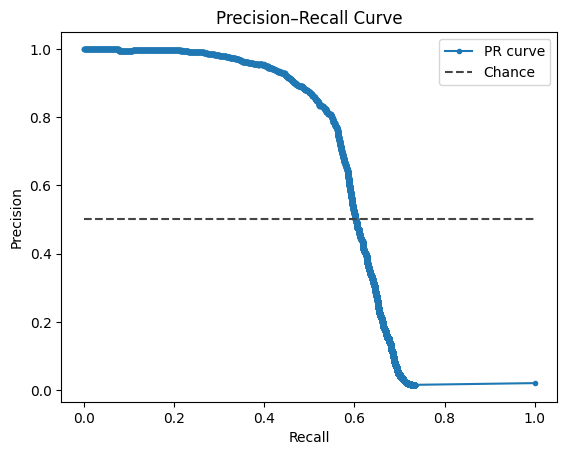

0.5960789447163115 [0.         0.02228996 0.02328442 ... 2.2692616  2.36477613 2.40169263]


In [59]:
precision, recall, thresholds = metrics.precision_recall_curve(matches_label, matches_scores)
ap = metrics.average_precision_score(matches_label, matches_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.hlines(0.5, 0, 1, colors="#454545", linestyles='dashed')
plt.legend(('PR curve', 'Chance'))
plt.show()
print(ap, thresholds)

In [65]:
print(thresholds[precision[:-1]>0.9], recall[precision>0.9])
print(precision[len(thresholds[thresholds<=0.46])], recall[len(thresholds[thresholds<=0.46])])

[0.46727508 0.46727532 0.46730587 ... 2.2692616  2.36477613 2.40169263] [0.46636546 0.46636546 0.46586345 ... 0.00100402 0.00050201 0.        ]
0.8959923664122137 0.4713855421686747


In [ ]:
thresholds = np.linspace(0, 0.5*np.pi, 100)
precision = np.sin(thresholds)
recall = np.cos(thresholds)


plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.hlines(1, 0, 1, colors="#FF0000")
plt.hlines(0.5, 0, 1, colors="#454545", linestyles='dashed')
plt.vlines(1, 0, 1, colors="#FF0000")
plt.legend(('PR curve example', 'Perfect PR curve', 'Chance'), loc= 3)
plt.show()

# Results
## Monthly

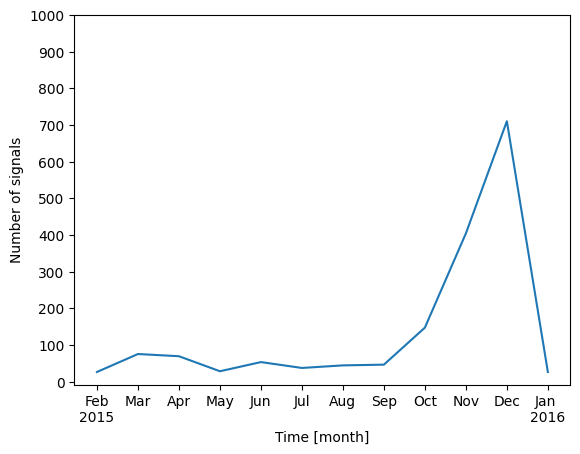

In [112]:
data_path = Path(r"C:\Users\noesc\Desktop\tonal")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]

year = np.array(['Jan \n'+data_names[-1][:4],'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
tonal = np.zeros(12)
m0 = int(data_names[0][4:6])
true_year = np.concatenate((year[m0-1:],year[:m0-1]))
true_year[0] = year[m0-1] + '\n' + data_names[0][:4]
for data in data_names:
    month = int(data[4:6])
    tonal[month-1-m0] += 1
    
plt.plot(true_year,tonal)
plt.xlabel('Time [month]')
plt.ylabel('Number of signals')
plt.yticks(np.arange(0, 1000.1, 100))
plt.show()

In [113]:
datasets_path = Path(r'E:')
datasets = [f.name for f in datasets_path.iterdir() if (f.is_dir() and len(f.name) == 4)]

for dataset in datasets:
    data_path = Path(r"E:\\"+dataset+r"\\tonal")
    data_names = [f.name for f in data_path.iterdir() if f.is_file()]

    year = np.array(['Jan\n'+ data_names[-1][:4],'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    tonal = np.zeros(12)
    m0 = int(data_names[0][4:6])
    true_year = np.concatenate((year[m0-1:],year[:m0-1]))
    true_year[0] = year[m0-1] + '\n' + data_names[0][:4]
    for data in data_names:
        month = int(data[4:6])
        tonal[month-1-m0] += 1
    plt.plot(true_year,tonal)
    plt.yticks(np.arange(0, 1000.1, 100))
    plt.xlabel('Time [month]')
    plt.ylabel('Number of signals')
    plt.title(dataset)
    plt.show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:'

## Daily

['20151104T191502.png', '20151106T090002.png', '20151107T213026.png', '20151109T083001.png', '20151110T123013.png', '20151112T233025.png', '20151113T000008.png', '20151113T011501.png', '20151113T013012.png', '20151113T040004.png', '20151113T051524.png', '20151113T053010.png', '20151113T054506.png', '20151113T054527.png', '20151113T063017.png', '20151113T064513.png', '20151113T070008.png', '20151113T073019.png', '20151113T080026.png', '20151113T084524.png', '20151113T091510.png', '20151113T094500.png', '20151113T094515.png', '20151113T100002.png', '20151113T100016.png', '20151113T101515.png', '20151113T103002.png', '20151113T104503.png', '20151113T104528.png', '20151113T120010.png', '20151113T131502.png', '20151113T131523.png', '20151113T154523.png', '20151113T164502.png', '20151113T170027.png', '20151113T173025.png', '20151113T180002.png', '20151113T180023.png', '20151113T181526.png', '20151113T183015.png', '20151113T184507.png', '20151113T204517.png', '20151113T211520.png', '20151113T

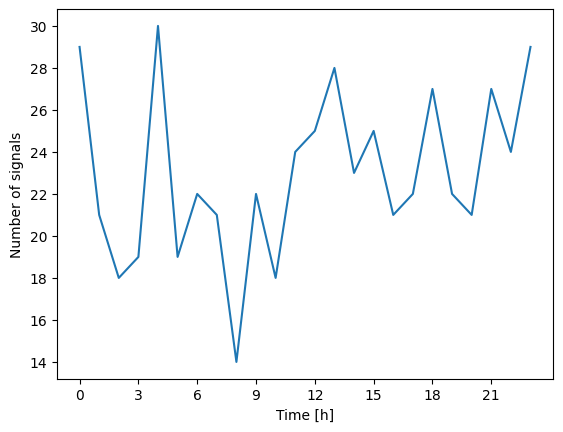

In [ ]:
data_path = Path(r"C:\Users\noesc\Desktop\tonal")
data_names = [f.name for f in data_path.iterdir() if (f.is_file() and (f.name.startswith('201511') or f.name.startswith('201512')))]

print(data_names)

day = np.arange(0,24,1)
tonal = np.zeros(24)
for data in data_names:
    hour = int(data[9:11])
    tonal[hour] += 1

plt.plot(day,tonal)
plt.xlabel('Time [h]')
plt.ylabel('Number of signals')
plt.xticks(np.arange(0,24,3))
plt.show()